# Task 2: Necessary and Sufficient Explanations

**Goal**: The goal of this task is to select a minimal number of explanations that after merging
(by the LLM) will satisfy your defined thresholds of readability and semantic similarity to your
ground truth

**Criteria**: Readability, Semantic Similarity to ground truth (choose a metric and justify)

In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from textstat import flesch_reading_ease
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

## Load GT & Raw Explanations

In [3]:
path = 'data/llm_gt_explanations'

gt_explanations = {}
for file in os.listdir(path):
    if file.endswith('.txt'):
        with open(os.path.join(path, file)) as f:
            gt_explanations[file[:-4]] = f.read()

path = 'data/correct_explanations'

raw_explanations = {}
for file in os.listdir(path):
    if file.endswith('.txt'):
        with open(os.path.join(path, file)) as f:
            content = f.read()
            explanations = [line.split(': ', 1)[1].strip() for line in content.splitlines() if line.strip()]
            raw_explanations[file[:-4]] = explanations

## Generate Explaination Samples (Varying Number Of Explanations)

In [4]:
def generate_sample_sizes(num_explanations):
    """Generate a list of sample sizes starting with 1,3,5 then incrementing by 5 until max."""
    sizes = [1, 3, 5]
    current = 10
    while current <= num_explanations:
        if current + 5 > num_explanations:
            # If next increment would exceed max, add the max and break
            if current != num_explanations:
                sizes.append(num_explanations)
            break
        sizes.append(current)
        current += 5
    return sizes

def sample_explanations(explanations, sample_size):
    """Sample explanations with given size."""
    try:
        if sample_size in [1, 3]:
            # For size 1 and 3, sample without replacement across all 3 samples
            all_samples = []
            used_indices = set()
            
            for _ in range(3):
                available = [i for i, x in enumerate(explanations) if i not in used_indices]
                if len(available) < sample_size:
                    return []
                    
                sample_indices = random.sample(available, sample_size)
                used_indices.update(sample_indices)
                sample = [explanations[i] for i in sample_indices]
                all_samples.append(sample)
                
            return all_samples
        else:
            return [random.sample(explanations, sample_size)]
    except ValueError:
        return []

# Set fixed seed for reproducibility
random.seed(42)

path = 'data/sampled_explanations'

# Main sampling logic
for bug, explanations in raw_explanations.items():
    sample_sizes = generate_sample_sizes(len(explanations))
    for size in sample_sizes:
        samples = sample_explanations(explanations, size)

        for i, sample in enumerate(samples, 1):
            # Create filename based on size and sample number
            if size in [1, 3]:
                filename = f"{bug}-{size}-{i}.txt"
            else:
                filename = f"{bug}-{size}.txt"
            
            # Write explanations to file
            with open(os.path.join(path, filename), 'w') as f:
                for j, explanation in enumerate(sample, 1):
                    f.write(f"{j}: {explanation}\n")

## Load Consolidated Explanations

**Prompt**

You are a developer whose job is to consolidate bug fixes based on the answers provided by colleagues of yours. Your professionalism is being measured by your ability to describe the bug as crisp, but still correct as possible such that another developer who actually has access to the codebase can fix the code in no time, without having to read through too much of your explanation. Make sure that your explanation contains all necessary and sufficient information to understand and fix the bug. Do not provide information on how to fix the bug, as this is the job of another developer. Only explain what the bug is.

*Attachment: Text file with sampled Explanations**

In [5]:
#path = 'data/llm_consolidated_Explanations'

#consolidated_explanations = {}
#for file in os.listdir(path):
#    if file.endswith('.txt'):
#        with open(os.path.join(path, file)) as f:
#            consolidated_explanations[file[:-4]] = f.read()

path = 'data/llm_consolidated_explanations'

consolidated_explanations = {}
for file in os.listdir(path):
    if file.endswith('.txt'):
        with open(os.path.join(path, file), encoding='utf-8') as f:
            consolidated_explanations[file[:-4]] = f.read()


## Calculate Readability Score

In [6]:
readability_scores = {}
for filename, consolidated_exp in consolidated_explanations.items():
    score = flesch_reading_ease(consolidated_exp)
    readability_scores[filename] = score


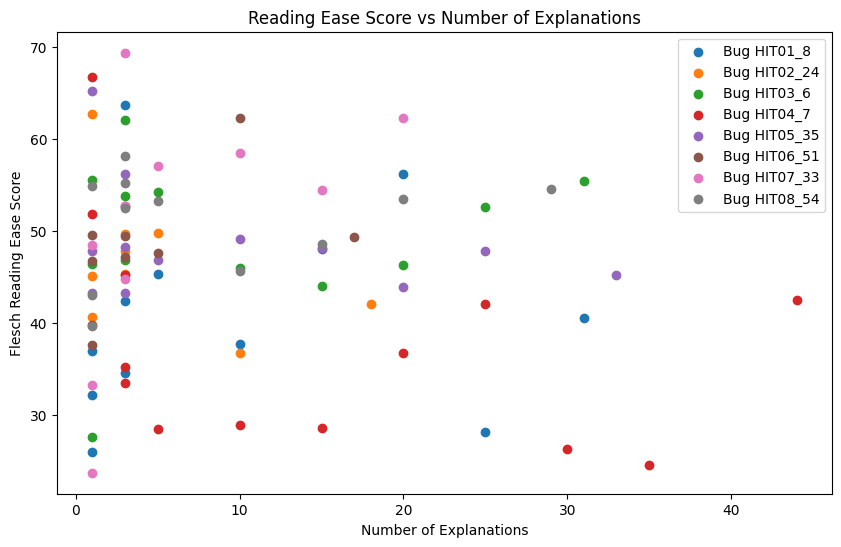

In [7]:
# Extract raw scores and group by bug ID
bug_data = {}  # Dictionary to store data points for each bug

for filename, score in readability_scores.items():
    parts = filename.split('-')
    if len(parts) >= 2:
        bug_id = parts[0]
        num_explanations = int(parts[1])
        
        if bug_id not in bug_data:
            bug_data[bug_id] = {'x': [], 'y': []}
            
        bug_data[bug_id]['x'].append(num_explanations)
        bug_data[bug_id]['y'].append(score)

# Create scatter plot
plt.figure(figsize=(10,6))

# Plot points for each bug with different colors
for bug_id in sorted(bug_data.keys()):
    data = bug_data[bug_id]
    plt.scatter(data['x'], data['y'], label=f'Bug {bug_id}')

plt.xlabel('Number of Explanations')
plt.ylabel('Flesch Reading Ease Score')
plt.title('Reading Ease Score vs Number of Explanations')
plt.legend()
plt.show()


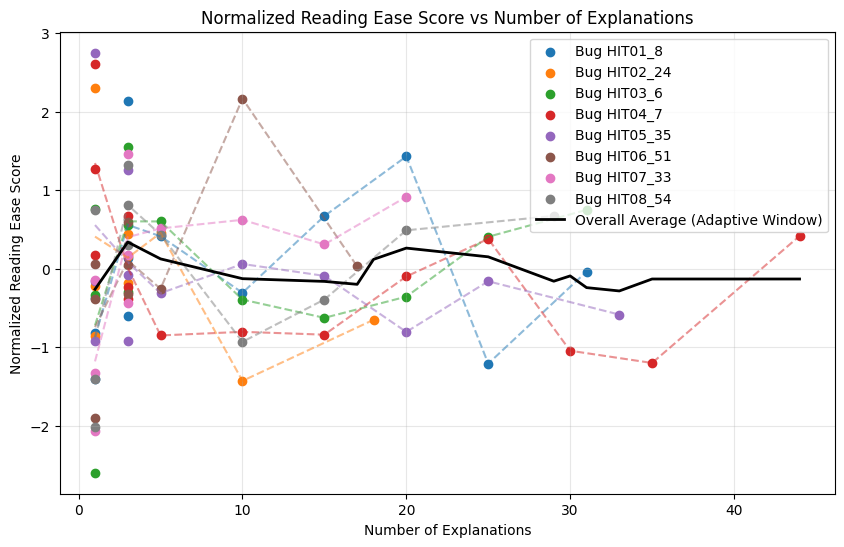

In [8]:
# Extract number of explanations, readability scores and bugs
data = {}  # Dictionary to store data per bug

# First pass: collect data and normalize scores
for filename, score in readability_scores.items():
    parts = filename.split('-')
    if len(parts) >= 2:
        bug_id = parts[0]
        num_explanations = int(parts[1])
        
        if bug_id not in data:
            data[bug_id] = {'x': [], 'y': []}
            
        data[bug_id]['x'].append(num_explanations)
        data[bug_id]['y'].append(score)

# Normalize scores for each bug
for bug_id, values in data.items():
    mean = np.mean(values['y'])
    std = np.std(values['y'])
    values['y'] = [(y - mean) / std for y in values['y']]

# Calculate overall average points
all_x_values = sorted(set(x for values in data.values() for x in values['x']))
overall_avg_y = []

# Calculate overall averages with adaptive window size
for i, x in enumerate(all_x_values):
    # Get all y values for current x
    current_y_vals = [values['y'][j] for values in data.values() 
                     for j, x_val in enumerate(values['x']) if x_val == x]
    
    if len(current_y_vals) >= 5:
        # If we have enough samples at current x, just use those
        overall_avg_y.append(sum(current_y_vals) / len(current_y_vals))
    else:
        # If we don't have enough samples, look at neighboring x values
        window_y_vals = current_y_vals.copy()
        left_idx = i - 1
        right_idx = i + 1
        
        # Keep adding values from left and right until we have enough or run out of x values
        while len(window_y_vals) < 5 and (left_idx >= 0 or right_idx < len(all_x_values)):
            if left_idx >= 0:
                left_x = all_x_values[left_idx]
                left_vals = [values['y'][j] for values in data.values() 
                           for j, x_val in enumerate(values['x']) if x_val == left_x]
                window_y_vals.extend(left_vals)
                left_idx -= 1
                
            if right_idx < len(all_x_values):
                right_x = all_x_values[right_idx]
                right_vals = [values['y'][j] for values in data.values() 
                            for j, x_val in enumerate(values['x']) if x_val == right_x]
                window_y_vals.extend(right_vals)
                right_idx += 1
        
        overall_avg_y.append(sum(window_y_vals) / len(window_y_vals))

# Create scatter plot
plt.figure(figsize=(10,6))

# Plot individual bugs with their averages
for bug_id in sorted(data.keys()):
    values = data[bug_id]
    plt.scatter(values['x'], values['y'], label=f'Bug {bug_id}')
    
    # Calculate and plot averages for each bug
    unique_x = sorted(set(values['x']))
    avg_y = [np.mean([values['y'][i] for i, xi in enumerate(values['x']) if xi == x_val]) 
             for x_val in unique_x]
    plt.plot(unique_x, avg_y, '--', alpha=0.5)

# Plot overall average with adaptive window
plt.plot(all_x_values, overall_avg_y, 'k-', linewidth=2, label='Overall Average (Adaptive Window)')

plt.xlabel('Number of Explanations')
plt.ylabel('Normalized Reading Ease Score')
plt.title('Normalized Reading Ease Score vs Number of Explanations')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# export normalized readability scores
import pandas as pd

exported_readability_scores = []
for bug_id, values in data.items():
    for x, y in zip(values['x'], values['y']):
        exported_readability_scores.append({'bug_id': bug_id, 'num_explanations': x, 'normalized_readability_score': y})

# Convert to DataFrame and save to CSV
df = pd.DataFrame(exported_readability_scores)
df.to_csv('data/exports/readability_scores.csv', index=False)


ModuleNotFoundError: No module named 'pandas'

## Calculate Semantic Similarity

In [10]:
# Load model
model = SentenceTransformer('all-mpnet-base-v2')

# Calculate semantic similarity for each consolidated explanation
similarities = {}
for filename, consolidated_exp in consolidated_explanations.items():
    # Extract bug ID from filename (everything before first underscore)
    bug = filename.split('-')[0]
    
    # Get ground truth explanation for this bug
    gt_exp = gt_explanations[bug]
    
    # Encode texts to vectors
    consolidated_vec = model.encode(consolidated_exp, convert_to_tensor=True)
    gt_vec = model.encode(gt_exp, convert_to_tensor=True)
    
    # Calculate cosine similarity using util function
    similarity = cos_sim(consolidated_vec, gt_vec)
    similarities[filename] = float(similarity[0][0])  # Convert from tensor to float

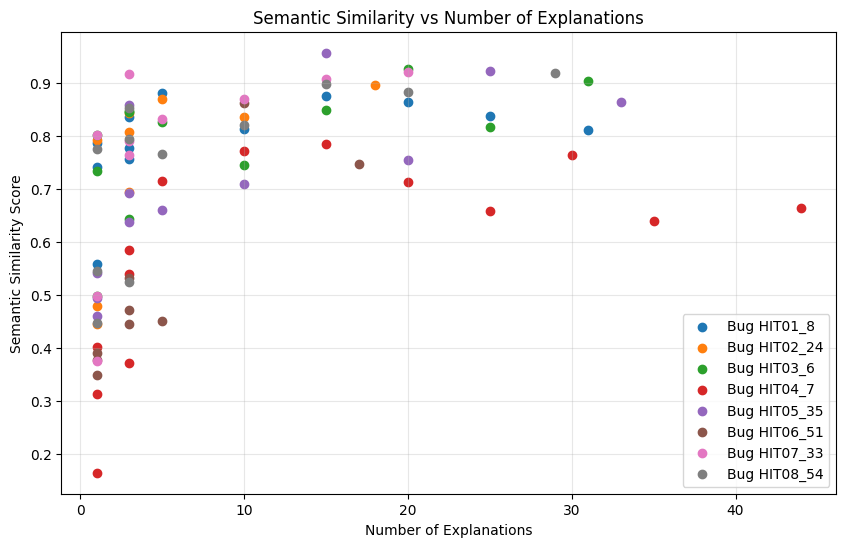

In [11]:
# Dictionary to store data per bug
data = {}

# Extract and organize data
for filename, similarity in similarities.items():
    bug_id = filename.split('-')[0]
    num_explanations = int(filename.split('-')[1])
    
    if bug_id not in data:
        data[bug_id] = {'x': [], 'y': []}
    data[bug_id]['x'].append(num_explanations)
    data[bug_id]['y'].append(similarity)

# Calculate statistics and averages
all_x_values = sorted(set(x for values in data.values() for x in values['x']))

# Plotting
plt.figure(figsize=(10,6))

# Plot individual bugs
for bug_id, values in sorted(data.items()):
    plt.scatter(values['x'], values['y'], label=f'Bug {bug_id}')

plt.xlabel('Number of Explanations')
plt.ylabel('Semantic Similarity Score')
plt.title('Semantic Similarity vs Number of Explanations')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

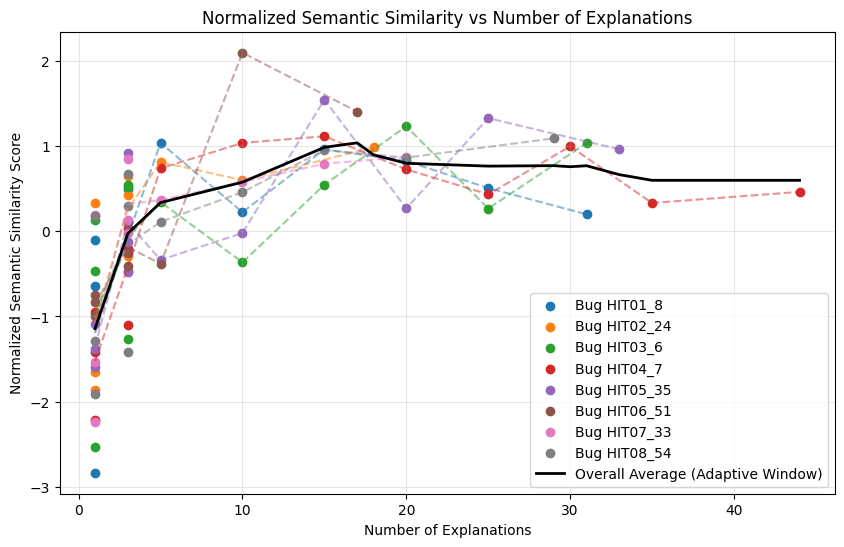

In [12]:
# Dictionary to store data per bug
data = {}

# Extract and organize data
for filename, similarity in similarities.items():
    bug_id = filename.split('-')[0]
    num_explanations = int(filename.split('-')[1])
    
    if bug_id not in data:
        data[bug_id] = {'x': [], 'y': []}
    data[bug_id]['x'].append(num_explanations)
    data[bug_id]['y'].append(similarity)

# Calculate statistics and averages
all_x_values = sorted(set(x for values in data.values() for x in values['x']))
overall_avg_y = []

# Normalize and calculate averages in one pass
for bug_id, values in data.items():
    # Normalize y values
    mean, std = np.mean(values['y']), np.std(values['y'])
    values['y'] = [(y - mean) / std for y in values['y']]
    
    # Calculate bug-specific averages
    values['avg_x'] = []
    values['avg_y'] = []
    for x in sorted(set(values['x'])):
        y_vals = [values['y'][i] for i, x_val in enumerate(values['x']) if x_val == x]
        values['avg_x'].append(x)
        values['avg_y'].append(sum(y_vals) / len(y_vals))

# Calculate overall averages with adaptive window size
for i, x in enumerate(all_x_values):
    # Get all y values for current x
    current_y_vals = [values['y'][j] for values in data.values() 
                     for j, x_val in enumerate(values['x']) if x_val == x]
    
    if len(current_y_vals) >= 5:
        # If we have enough samples at current x, just use those
        overall_avg_y.append(sum(current_y_vals) / len(current_y_vals))
    else:
        # If we don't have enough samples, look at neighboring x values
        window_y_vals = current_y_vals.copy()
        left_idx = i - 1
        right_idx = i + 1
        
        # Keep adding values from left and right until we have enough or run out of x values
        while len(window_y_vals) < 5 and (left_idx >= 0 or right_idx < len(all_x_values)):
            if left_idx >= 0:
                left_x = all_x_values[left_idx]
                left_vals = [values['y'][j] for values in data.values() 
                           for j, x_val in enumerate(values['x']) if x_val == left_x]
                window_y_vals.extend(left_vals)
                left_idx -= 1
                
            if right_idx < len(all_x_values):
                right_x = all_x_values[right_idx]
                right_vals = [values['y'][j] for values in data.values() 
                            for j, x_val in enumerate(values['x']) if x_val == right_x]
                window_y_vals.extend(right_vals)
                right_idx += 1
        
        overall_avg_y.append(sum(window_y_vals) / len(window_y_vals))

# Plotting
plt.figure(figsize=(10,6))

# Plot individual bugs
for bug_id, values in sorted(data.items()):
    plt.scatter(values['x'], values['y'], label=f'Bug {bug_id}')
    plt.plot(values['avg_x'], values['avg_y'], '--', alpha=0.5)

# Plot overall average
plt.plot(all_x_values, overall_avg_y, 'k-', linewidth=2, label='Overall Average (Adaptive Window)')

plt.xlabel('Number of Explanations')
plt.ylabel('Normalized Semantic Similarity Score')
plt.title('Normalized Semantic Similarity vs Number of Explanations')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()